In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [24]:
# Definition of a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data_path, train_size):
        self.data = datasets.FashionMNIST(data_path, download=True, transform=transforms.ToTensor())
        self.train_size = train_size
        self.split_dataset()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

    def split_dataset(self):
        num_train = int(self.train_size * len(self.data))
        self.data, _ = torch.utils.data.random_split(self.data, [num_train, len(self.data) - num_train])

# Definition of a custom collate function
def custom_collate(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)
    return images, labels

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [25]:
# Definition of the model with one hidden layer
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [26]:
# Definition of the model with two hidden layers
class SimpleModel2Layers(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleModel2Layers, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [27]:
# Define the evaluate_model function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1

In [28]:
# Initialization of the list to store training losses for each hidden size, batch size, and training set size
hidden_sizes = [100, 150, 200, 250]
hidden_size2 = 50
batch_sizes = [4, 8, 16, 24]
train_sizes = [0.5, 0.1, 0.01]
train_losses_per_config = []
train_losses_per_config2 = []
num_epochs = 5

Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [1/5], Loss: 0.5359
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [2/5], Loss: 0.4021
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [3/5], Loss: 0.3636
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [4/5], Loss: 0.3399
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [5/5], Loss: 0.3205
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [1/5], Loss: 0.5612
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [2/5], Loss: 0.4136
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [3/5], Loss: 0.3718
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [4/5], Loss: 0.3466
Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Epoch [5/5], Loss: 0.3312
1 layer-  Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Accuracy: 0.8979, Precision: 0.8978, Recall: 0.8979, F1 Score: 0.8976
2 layers- Train Size: 0.5, Hidden Size: 100, Batch Size: 4, Accuracy: 0.8893, Precision: 0.8907, Recall: 0.889

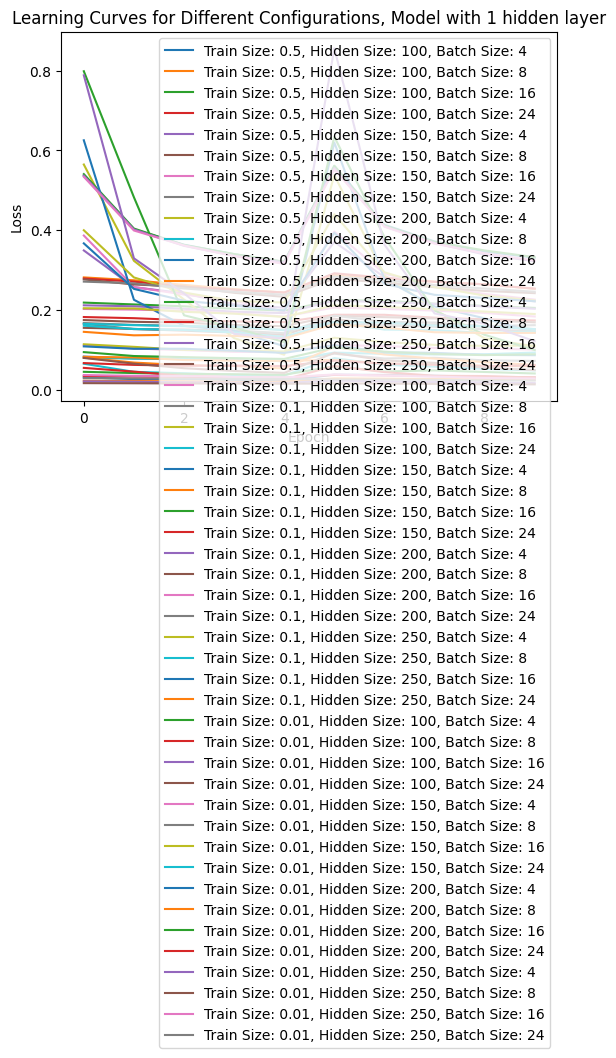

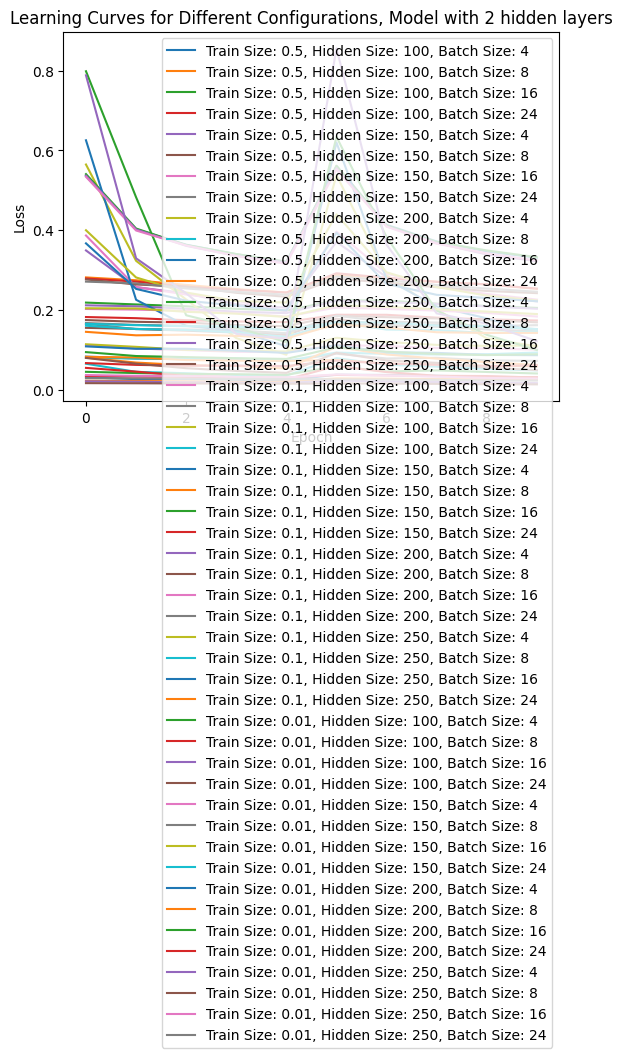

In [29]:
# Iterate over different configurations
for hidden_size in hidden_sizes:
    model = SimpleModel(input_size=28 * 28, hidden_size=hidden_size, num_classes=10)
    model2 = SimpleModel2Layers(input_size=28 * 28, hidden_size1=hidden_size, hidden_size2=hidden_size2, num_classes=10)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
    for train_size in train_sizes:
        custom_dataset = CustomDataset('path', train_size)
        for batch_size in batch_sizes:
            custom_data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

            # Move the model to device (CPU or GPU)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # Initialization of the list to store training losses
            train_losses = []
            train_losses2 = []

            # Definition of the train_model function
            def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
                model.train()
                for epoch in range(num_epochs):
                    epoch_loss = 0.0  # Initialize the epoch loss
                    for images, labels in train_loader:
                        images, labels = images.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        # Add the batch loss to the epoch loss
                        epoch_loss += loss.item()

                    # Calculate the average loss for the epoch
                    average_epoch_loss = epoch_loss / len(train_loader)

                    # Append the average epoch loss to the list
                    train_losses.append(average_epoch_loss)

                    # Print the average epoch loss
                    print(f'Train Size: {train_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Epoch [{epoch + 1}/{num_epochs}], Loss: {average_epoch_loss:.4f}')

                return train_losses

            # Training the model
            train_losses_per_config.append(train_model(model, custom_data_loader, criterion, optimizer, device, num_epochs))
            train_losses_per_config2.append(train_model(model2, custom_data_loader, criterion, optimizer2, device, num_epochs))

            # Evaluate the model and calculate metrics
            accuracy, precision, recall, f1 = evaluate_model(model, custom_data_loader, device)
            accuracy2, precision2, recall2, f12 = evaluate_model(model2, custom_data_loader, device)
            # evaluation_metrics_per_config.append((train_size, hidden_size, batch_size, accuracy, precision, recall, f1))
            print(f'1 layer-  Train Size: {train_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
            print(f'2 layers- Train Size: {train_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Accuracy: {accuracy2:.4f}, Precision: {precision2:.4f}, Recall: {recall2:.4f}, F1 Score: {f12:.4f}')


# # Plot the learning curves for each configuration
# for i, train_size in enumerate(train_sizes):
#     for j, hidden_size in enumerate(hidden_sizes):
#         for k, batch_size in enumerate(batch_sizes):
#             plt.plot(train_losses_per_config[i * len(hidden_sizes) * len(batch_sizes) + j * len(batch_sizes) + k], label=f'Train Size: {train_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Learning Curves for Different Configurations, Model with 1 hidden layer')
# plt.legend()
# plt.show()

# # Plot the learning curves for each configuration
# for i, train_size in enumerate(train_sizes):
#     for j, hidden_size in enumerate(hidden_sizes):
#         for k, batch_size in enumerate(batch_sizes):
#             plt.plot(train_losses_per_config2[i * len(hidden_sizes) * len(batch_sizes) + j * len(batch_sizes) + k], label=f'Train Size: {train_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Learning Curves for Different Configurations, Model with 2 hidden layers')
# plt.legend()
# plt.show()


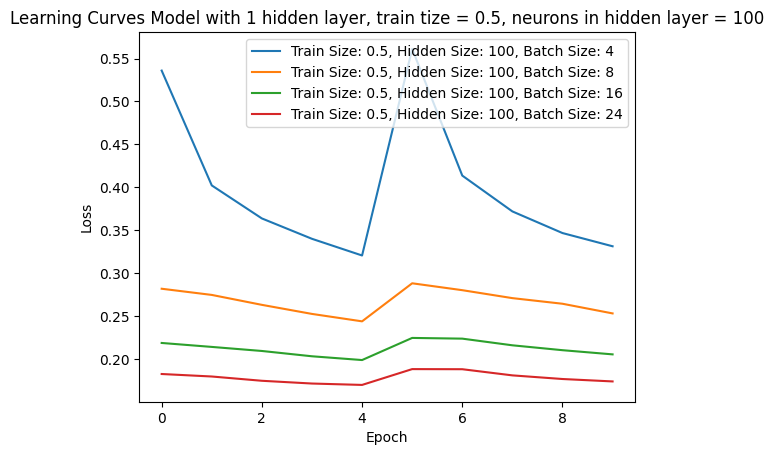

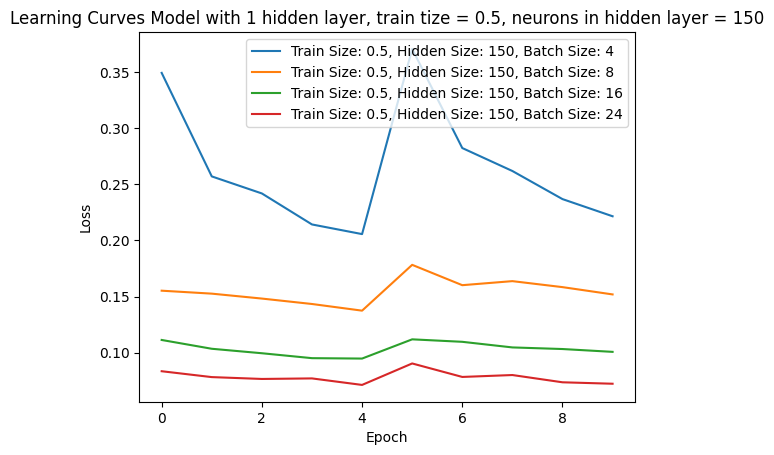

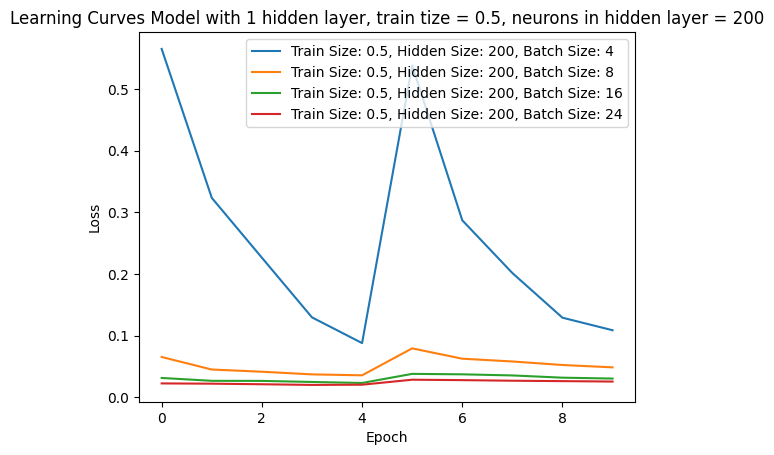

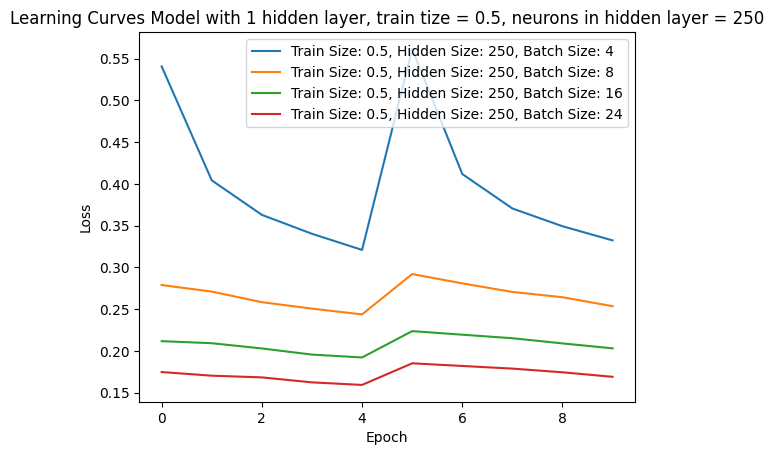

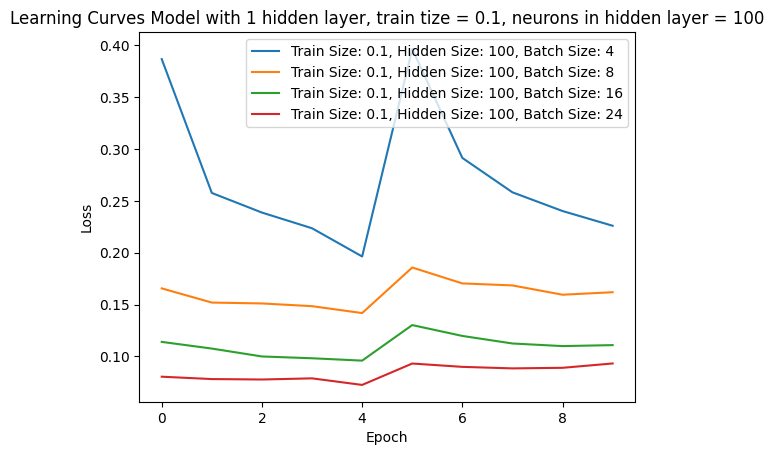

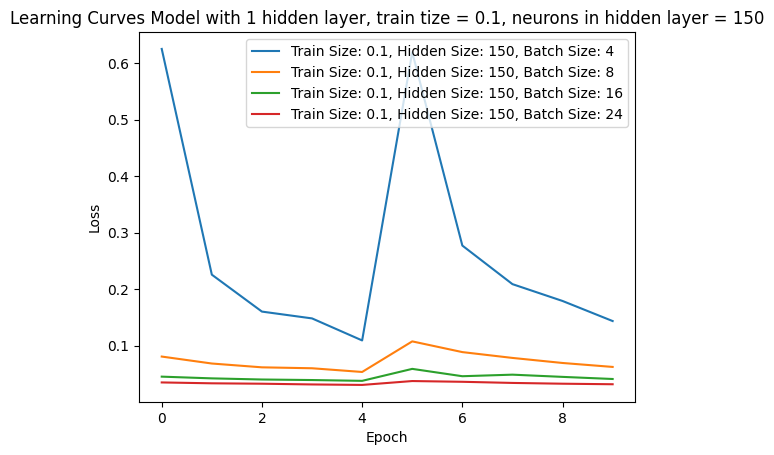

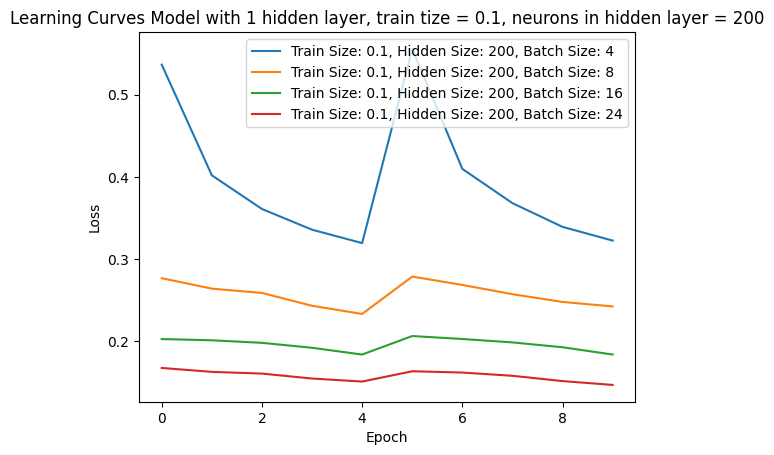

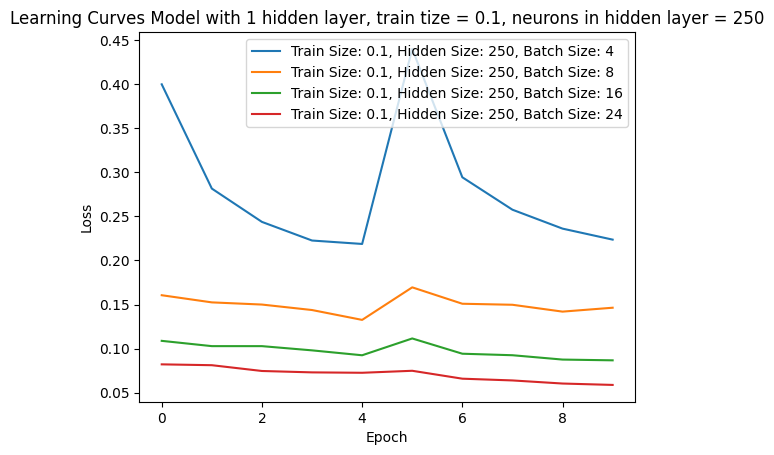

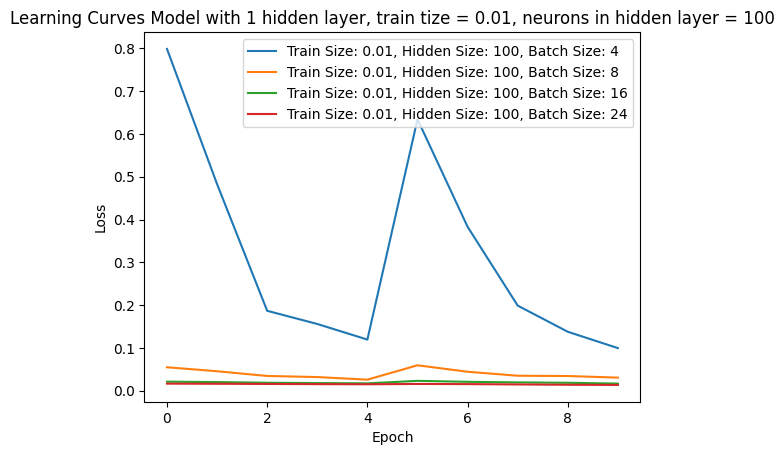

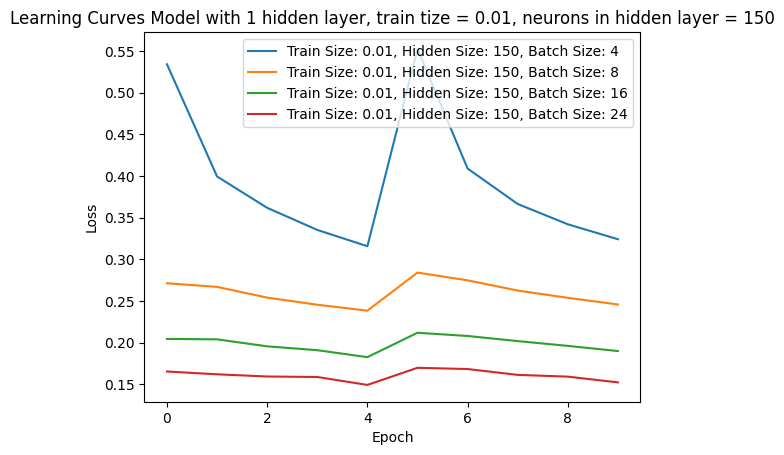

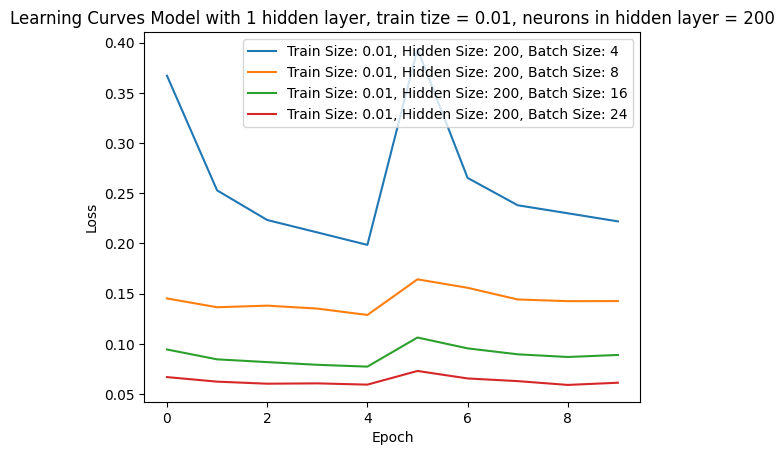

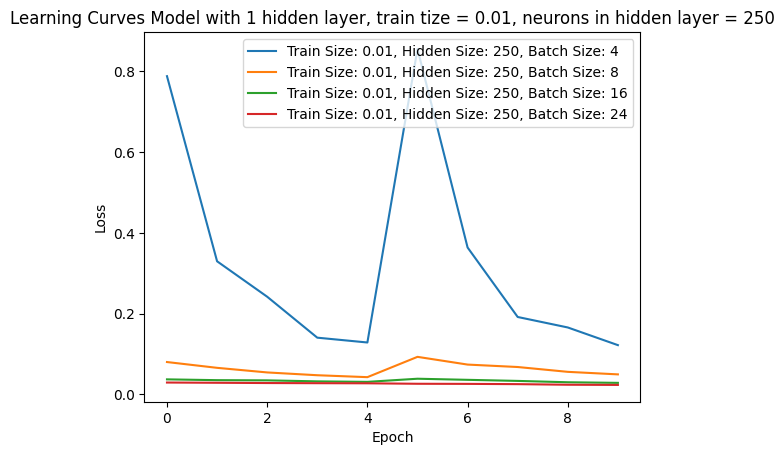

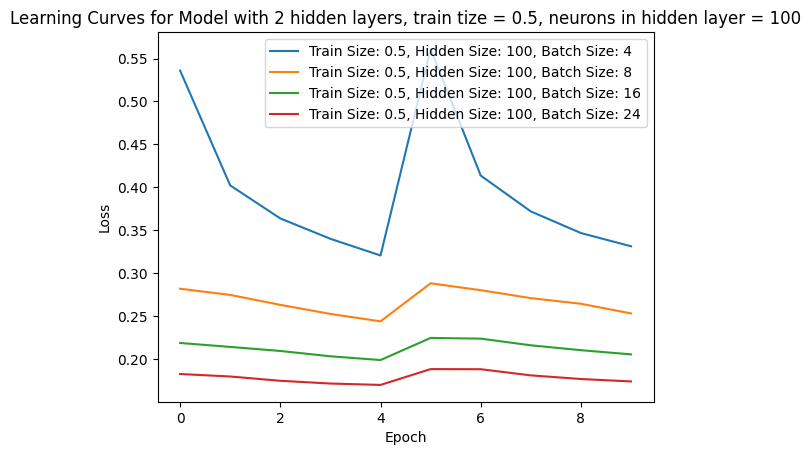

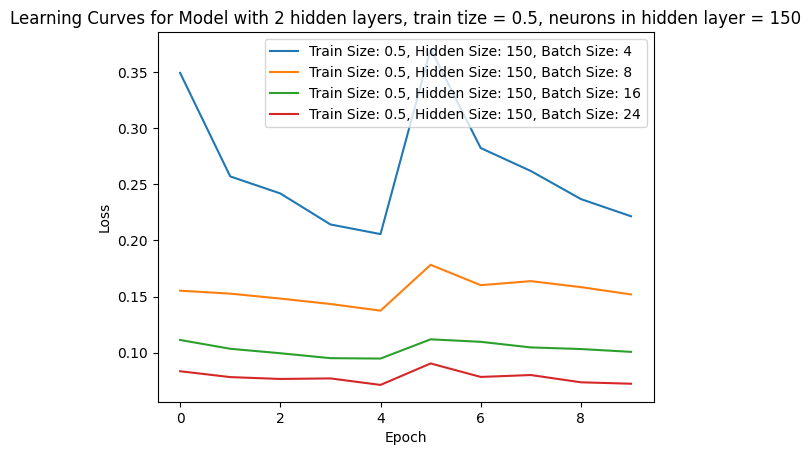

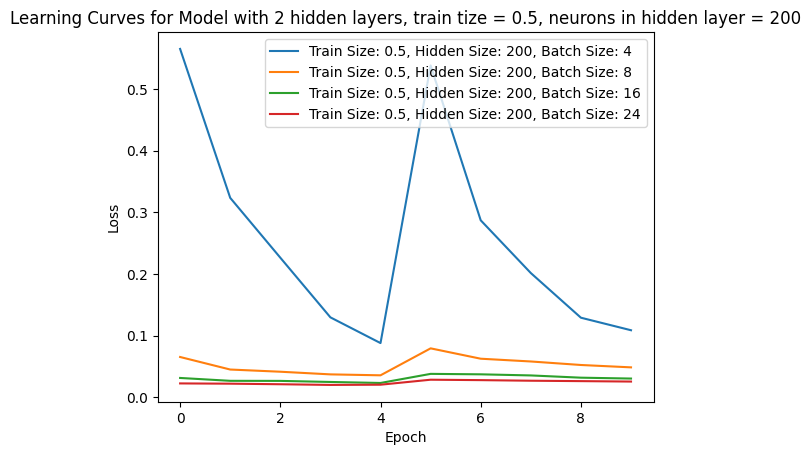

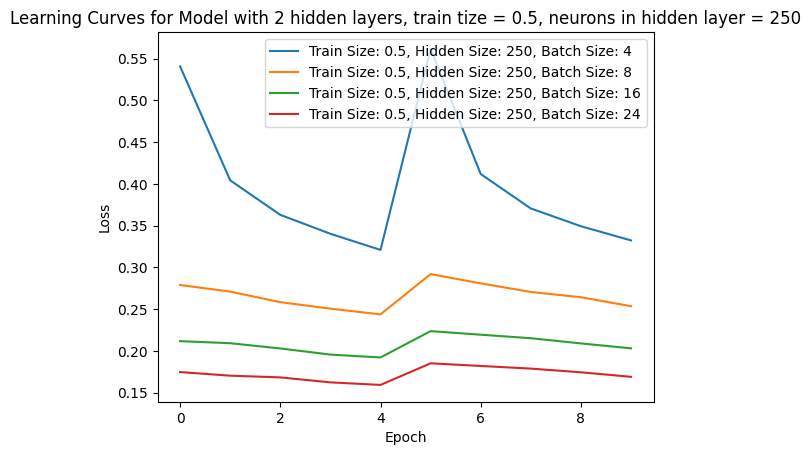

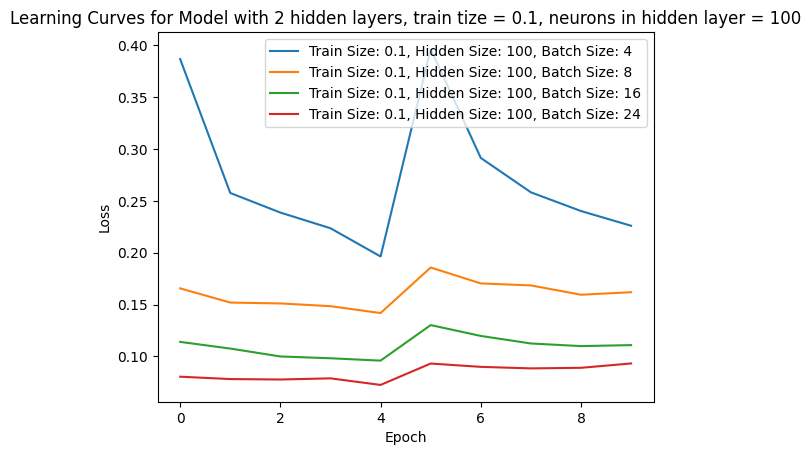

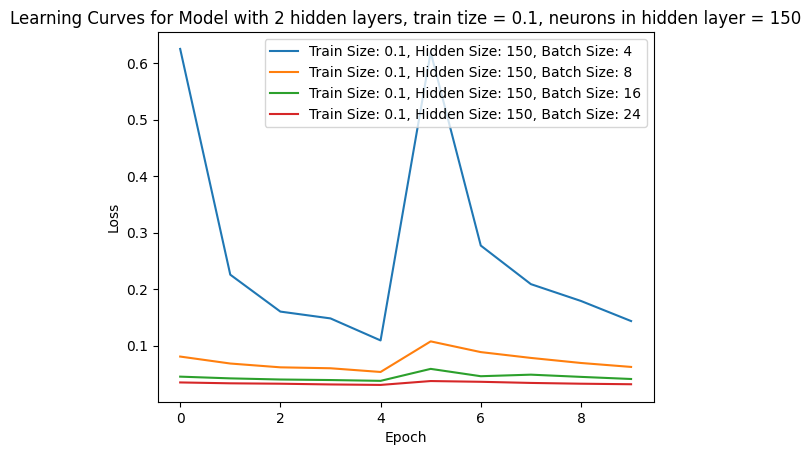

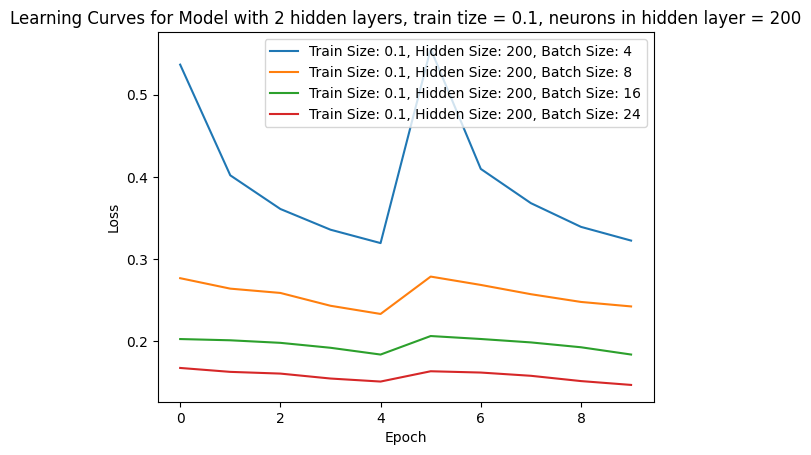

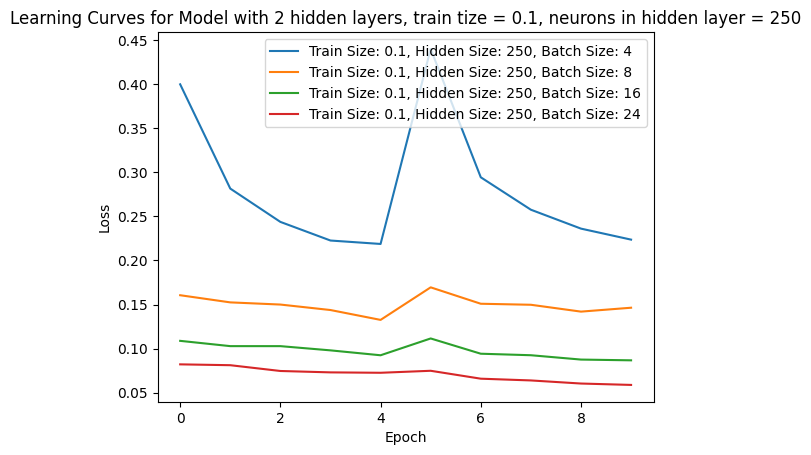

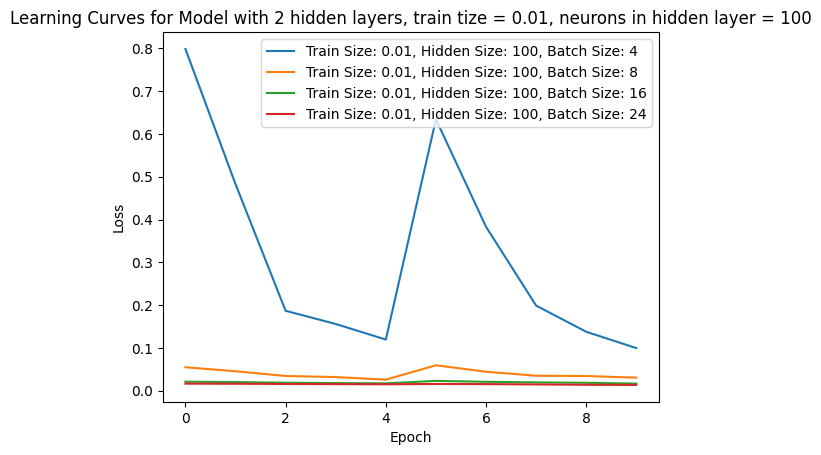

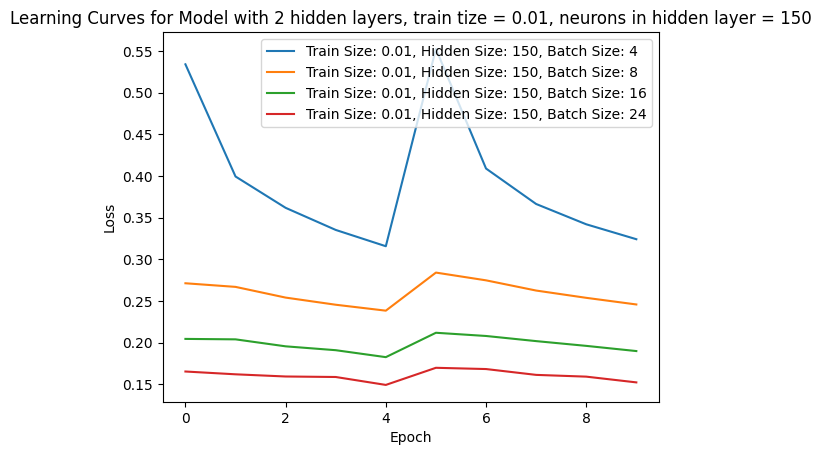

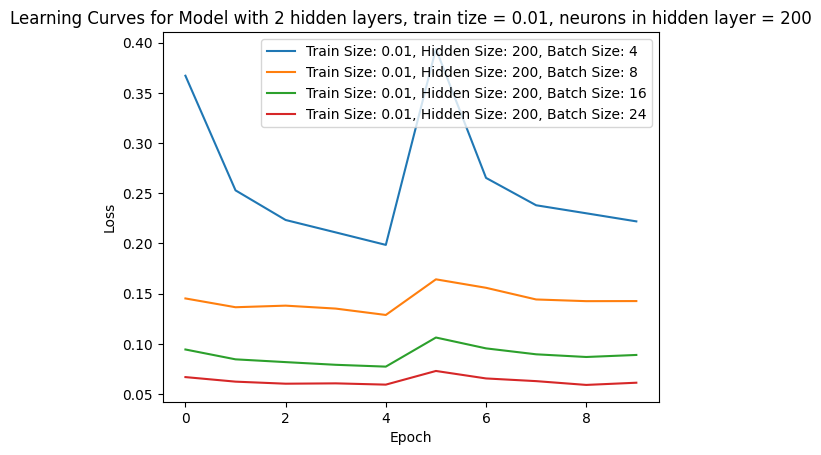

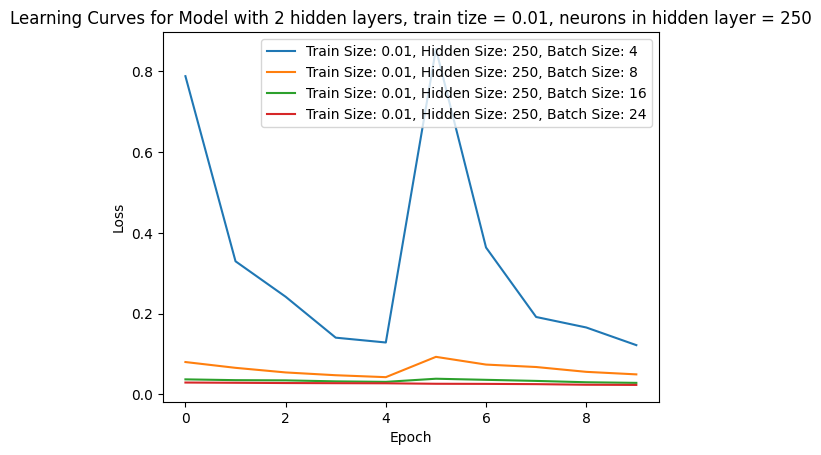

In [30]:
# Plot the learning curves for each configuration
for i, train_size in enumerate(train_sizes):
    for j, hidden_size in enumerate(hidden_sizes):
        for k, batch_size in enumerate(batch_sizes):
            plt.plot(train_losses_per_config[i * len(hidden_sizes) * len(batch_sizes) + j * len(batch_sizes) + k], label=f'Train Size: {train_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Learning Curves Model with 1 hidden layer, train tize = {train_size}, neurons in hidden layer = {hidden_size}')
        plt.legend()
        plt.show()

# Plot the learning curves for each configuration
for i, train_size in enumerate(train_sizes):
    for j, hidden_size in enumerate(hidden_sizes):
        for k, batch_size in enumerate(batch_sizes):
            plt.plot(train_losses_per_config2[i * len(hidden_sizes) * len(batch_sizes) + j * len(batch_sizes) + k], label=f'Train Size: {train_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Learning Curves for Model with 2 hidden layers, train tize = {train_size}, neurons in hidden layer = {hidden_size}')
        plt.legend()
        plt.show()

In [32]:
print(train_losses_per_config2[0 * len(hidden_sizes) * len(batch_sizes) + 0 * len(batch_sizes) + 0])

[0.5359289342458127, 0.40211361388639855, 0.36363993557303853, 0.33990216759986974, 0.3204657592109174, 0.5611725002935467, 0.41356519209168713, 0.371817094691437, 0.3466165599426327, 0.33120536087154795]
